In [234]:
from pathlib import Path
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import TweedieRegressor
from itertools import compress

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

from mne_bids import BIDSPath
import mne

import json
import pandas as pd
from datetime import date, datetime
import math

## Set up Hyperparameters

In [235]:
subject_nums = [22, 11, 11]
resample = True

#### Create a Disabled CV class so we can use grid search functionality without performing KFold Cross Validation

In [236]:
class DisabledCV:
    """Dummy CV class for SearchCV scikit-learn functions."""

    def __init__(self):
        self.n_splits = 1

    def split(self, X, y, groups=None):
        """Disabled split."""
        yield (np.arange(len(X)), np.arange(len(y)))

    def get_n_splits(self, X, y, groups=None):
        """Disabled split."""
        return self.n_splitsFAF

### Set up path variables

In [237]:
bids_root = Path("D:/ScalpData/jhh_round4")
sourcedir = bids_root / "sourcedata"
deriv_root = bids_root / "derivatives"
deriv_chain = "origsampling/sourcesink/monopolar"
deriv_path = deriv_root / deriv_chain

### Get patients

In [238]:
subject_map_fpath = "D:/Desktop/ezscalp/scripts/jhu_pt_map.json"
with open(subject_map_fpath) as f:
    subject_dict = json.load(f)

In [239]:
metadata_fpath = Path("D:/ScalpData/JHU-metadata_June2021.csv")
meta = pd.read_csv(metadata_fpath)
# add our subject ids in new column
jhu_ids = meta['Record ID']
study_ids = [subject_dict[str(jid)] for jid in jhu_ids]
meta['Study ID'] = study_ids
# add subject age
dob = meta['date of birth '].to_list()
today = date.today()
ages = np.empty((len(meta), 1))
for ind, bd in enumerate(dob):
    if not isinstance(bd, float):
        birthDate = datetime.strptime(bd, '%m/%d/%Y')
        age = today.year - birthDate.year - ((today.month, today.day) < (birthDate.month, birthDate.day))
        ages[ind] = age
for ind, age in enumerate(ages):
    if age < 1:
        ages[ind] = np.nan
    else:
        ages[ind] = int(np.round(age))
meta['Age'] = ages
meta

,Record ID,First EEG (normal vs abnormal),epileptiform EEG,Type of abnormality,number of AEDs during first eeg,Final diagnosis,type of epilepsy,type of focal epilepsy,location of extra-temporal,date of birth,Comments,Study ID,Age
0,1,NaN,No,NaN,NaN,epilepsy,focal,extra-temporal,frontal,NaN,NaN,101,NaN
1,2,abnormal,Yes,NaN,0.0,epilepsy,NaN,NaN,NaN,NaN,NaN,201,NaN
2,3,NaN,Yes,NaN,1.0,epilepsy,generalized,NaN,NaN,NaN,NaN,202,NaN
3,4,NaN,No,NaN,1.0,epilepsy,focal,extra-temporal,NaN,NaN,NaN,203,NaN
4,5,NaN,Yes,NaN,0.0,epilepsy,focal,temporal,NaN,NaN,NaN,204,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,71,normal,No,NaN,1.0,PNES,NaN,NaN,NaN,7/28/1975,NaN,023,45.0
71,72,normal,No,NaN,1.0,epilepsy,focal,temporal,NaN,6/7/1975,NaN,123,46.0
72,73,normal,No,NaN,1.0,PNES,NaN,NaN,NaN,3/14/1952,NaN,024,69.0
73,74,normal,No,NaN,2.0,PNES,NaN,NaN,NaN,NaN,NaN,025,NaN


In [240]:
sfiles = sourcedir.glob("*.edf")
subs = [s.name.replace(".edf","") for s in sfiles]
subjects = [subject_dict[s] for s in subs]
nsub = len(subjects)

### Set up labels

In [241]:
labels = [int(s[0]) for s in subjects]

### Set up feature matrix

In [242]:
feature_mat = np.zeros((nsub, 5))

In [243]:
for ind, sub in enumerate(subjects):
    subject_deriv_path = deriv_path / f"sub-{sub}"
    kldiv_fpath = f"sub-{sub}_ses-initialvisit_task-monitor_run-01_desc-sourcesinkkldiv_ieeg.npy"
    entropy_fpath = f"sub-{sub}_ses-initialvisit_task-monitor_run-01_desc-sourcesinkentropy_ieeg.npy"
    kurtosis_fpath = f"sub-{sub}_ses-initialvisit_task-monitor_run-01_desc-sourcesinkkurtosis_ieeg.npy"
    skew_fpath = f"sub-{sub}_ses-initialvisit_task-monitor_run-01_desc-sourcesinkskew_ieeg.npy"
    variance_fpath = f"sub-{sub}_ses-initialvisit_task-monitor_run-01_desc-sourcesinkvariance_ieeg.npy"
    
    kldiv = np.load(subject_deriv_path / kldiv_fpath)
    entropy = np.load(subject_deriv_path / entropy_fpath)
    kurtosis = np.load(subject_deriv_path / kurtosis_fpath)
    skew = np.load(subject_deriv_path / skew_fpath)
    variance = np.load(subject_deriv_path / variance_fpath)
    
    feature_mat[ind, 0] = kldiv
    feature_mat[ind, 1] = entropy
    feature_mat[ind, 2] = kurtosis
    feature_mat[ind, 3] = skew
    feature_mat[ind, 4] = variance

Optional resampling

In [244]:
def _resample_patients(X, y, subject_nums, group_inds, pt_ids):
    if all([sn == -1 for sn in subject_nums]):
        return X, y, pt_ids, group_inds
    non_epilepsy_inds_ = [i for i, g in enumerate(group_inds) if g == 0]
    epilepsy_normal_inds_ = [i for i, g in enumerate(group_inds) if g == 1]
    epilepsy_abnormal_inds_ = [i for i, g in enumerate(group_inds) if g == 2]
    n_non_epilepsy = subject_nums[0]
    n_epilepsy_normal = subject_nums[1]
    n_epilepsy_abnormal = subject_nums[2]
    non_epilepsy_inds = np.random.choice(non_epilepsy_inds_, (n_non_epilepsy, 1), False)
    epilepsy_normal_inds = np.random.choice(epilepsy_normal_inds_, (n_epilepsy_normal, 1), False)
    epilepsy_abnormal_inds = np.random.choice(epilepsy_abnormal_inds_, (n_epilepsy_abnormal, 1), False)
    keep_inds = np.concatenate((non_epilepsy_inds, epilepsy_normal_inds, epilepsy_abnormal_inds))
    keep_inds.sort(kind='mergesort')
    keep_inds = [k[0] for k in keep_inds]
    X = X[keep_inds, :]
    y = y[keep_inds]
    pt_ids = pt_ids[keep_inds]
    group_inds = np.array(group_inds)
    group_inds = group_inds[keep_inds]
    return X, y, pt_ids, group_inds

## Set up Regressor

In [267]:
def KFoldPlot(reg, X, y, pt_ids, group_ids, n_feats, n_folds=9, verbose=True):
    if n_folds == 1:
        cv = DisabledCV()
    else:
        cv = KFold(n_splits=n_folds, shuffle=True, random_state=22)
    predictions_ep_ep = []
    predictions_ep_norm = []
    predictions_no_ep = []
    groups_ep_ep = []
    groups_ep_norm = []
    groups_no_ep = []
    pt_ids_ep_ep = []
    pt_ids_ep_norm = []
    pt_ids_no_ep = []
    g = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        _, pt_id_test = pt_ids[train_index], pt_ids[test_index]
        X_train = X_train.reshape((-1, n_feats-1))
        y_train = y_train.reshape((-1, 1))
        reg.fit(X_train, y_train)
        coeff_ = reg.coef_
        intercept = reg.intercept_

        X_test = X_test.reshape((-1, n_feats-1))
        y_test = y_test.reshape((-1, 1))
        coeff = np.hstack((intercept, coeff_)).reshape(n_feats, 1)
        if verbose:
            print(f"coeffs:\n {coeff}")
        X_new = np.hstack((np.ones((len(y), 1)), X_train))

        inner = np.dot(X_new, coeff)

        phat_ = np.divide(np.exp(inner), 1 + np.exp(inner))
        phat = [p[0] for p in phat_]
        y_pred = reg.predict(X_test)
        y_pred = phat
        #y_bool = list(map(bool, y_test))
        #y_non = [not bl for bl in y_bool]
        y_ep_ep = [g == 2 for g in group_ids]
        y_ep_norm = [g == 1 for g in group_ids]
        y_no_ep = [g == 0 for g in group_ids]
        #y_ep_norm = [y_ep_norm, y_ep_ep]
        y_pred_ep_ep = list(compress(y_pred, y_ep_ep))
        y_pred_ep_norm = list(compress(y_pred, y_ep_norm))
        y_pred_no_ep = list(compress(y_pred, y_no_ep))
        #y_pred_ep_norm = [y_pred_ep_norm, y_pred_ep_ep]
        
        predictions_ep_norm.extend(y_pred_ep_norm)
        predictions_ep_norm.extend(y_pred_ep_ep)
        predictions_no_ep.extend(y_pred_no_ep)
        pt_id_ep_ep = list(compress(pt_id_test, y_ep_ep))
        if verbose:
            print(f"ep_ep: {pt_id_ep_ep}")
        pt_id_ep_norm = list(compress(pt_id_test, y_ep_norm))
        if verbose:
            print(f"ep_norm: {pt_id_ep_norm}")
        pt_id_no_ep = list(compress(pt_id_test, y_no_ep))
        if verbose:
            print(f"nep: {pt_id_no_ep}")
        
        pt_ids_ep_norm.extend(pt_id_ep_norm)
        pt_ids_ep_norm.extend(pt_id_ep_ep)
        pt_ids_no_ep.extend(pt_id_no_ep)
        #groups_ep_ep.extend([g] * len(y_pred_ep_ep))
        groups_ep_norm.extend([g] * len(y_pred_ep_norm))
        groups_ep_norm.extend([g] * len(y_pred_ep_ep))
        groups_no_ep.extend([g] * len(y_pred_no_ep))
        g += 1
        if verbose:
            #score = reg.score(X_test, y_test)
            #print(f"score: {score}")
            print('hi')

    cmap = plt.cm.get_cmap("jet", 100)
    
    data = [predictions_no_ep, predictions_ep_norm]
    data = np.array(data)
    fig, ax = plt.subplots()
    ax.boxplot(data)
    handles = []
    x_scatter = []
    y_scatter = []
    pt_labels = []
    for i in range(1, 10):
        g_ep_ep = [e == i for e in groups_ep_ep]
        g_ep_norm = [e == i for e in groups_ep_norm]
        g_nep = [e == i for e in groups_no_ep]

        color = cmap(i)
        y_ep_ep = list(compress(predictions_ep_ep, g_ep_ep))
        y_ep_norm = list(compress(predictions_ep_norm, g_ep_norm))
        y_nep = list(compress(predictions_no_ep, g_nep))
        x_ep_ep = np.random.normal(2, 0.04, size=len(y_ep_ep))
        x_ep_norm = np.random.normal(2, 0.04, size=len(y_ep_norm))
        x_nep = np.random.normal(1, 0.04, size=len(y_nep))
        handle = ax.scatter(x_ep_ep, y_ep_ep, c=cmap(i), alpha=0.6, label=f"Fold{i}")
        handles.append(handle)
        x_scatter.extend(x_ep_ep)
        x_scatter.extend(x_ep_norm)
        x_scatter.extend(x_nep)
        y_scatter.extend(y_ep_ep)
        y_scatter.extend(y_ep_norm)
        y_scatter.extend(y_nep)
        # ax.scatter(x_nep, y_nep, c=cmap(i), alpha=0.6)
        # ax.scatter(x_ep, y_ep, c=cmap(i), alpha=0.6)

        pt_ep_ep = list(compress(pt_ids_ep_ep, g_ep_ep))
        pt_ep_norm = list(compress(pt_ids_ep_norm, g_ep_norm))
        pt_nep = list(compress(pt_ids_no_ep, g_nep))
        pt_labels.extend(pt_ep_ep)
        pt_labels.extend(pt_ep_norm)
        pt_labels.extend(pt_nep)

    [print(f"{pt_labels[ind]}: {y_scatter[ind]}") for ind, y in enumerate(y_scatter)]
    sc = plt.scatter(x_scatter, y_scatter, alpha=0.6)
    annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    #plt.axhline(y=0.64, color='r', linestyle='--')
    annot.set_visible(False)

    # plt.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', fontsize='xx-small')
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['no-epilepsy', 'epilepsy-normal', 'epilepsy-epileptiform'])
    ax.set_ylabel('p_epilepsy')
    return data, pt_labels, x_scatter, y_scatter

C:\Users\patri\.virtualenvs\episcalp-235KLvvi\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided

coeffs:
 [[ 4.99998372e-01]
 [-3.15328774e-03]
 [ 3.30629097e-03]
 [ 4.03254356e-02]
 [-2.14444004e-03]
 [-1.73535045e-05]]
ep_ep: ['202', '217', '224', '213', '225', '226', '204', '220', '219', '209', '218']
ep_norm: ['110', '104', '105', '103', '101', '114', '111', '117', '109', '112', '102']
nep: ['010', '009', '019', '003', '005', '018', '002', '001', '014', '007', '004', '020', '021', '011', '015', '006', '016', '022', '013', '017', '008', '012']
hi
110: 0.6089526188385893
104: 0.615418691106049
105: 0.6426089505525361
103: 0.6575037287217743
101: 0.6171539052329157
114: 0.6163403456530226
111: 0.6424800133965273
117: 0.6161771360197839
109: 0.6173144017707742
112: 0.6293369287061658
102: 0.6137693634633167
202: 0.6169160654381657
217: 0.616935192234036
224: 0.6322429161723131
213: 0.6238952037017513
225: 0.6172140793359409
226: 0.6143033857622255
204: 0.6083895700922907
220: 0.6450824870008611
219: 0.6257794193143476
209: 0.6146420304773753
218: 0.6417810105539816
010: 0.62149308

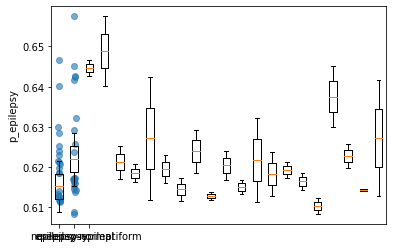

In [268]:
X = feature_mat
y = np.array([lab > 0 for lab in labels])
group_inds = np.array(labels)
pt_ids = np.array(subjects)
if resample:
    X, y, pt_ids, group_inds = _resample_patients(X, y, subject_nums, group_inds, pt_ids)

reg = TweedieRegressor(power=0)
cmap = plt.cm.get_cmap("jet", 100)

data, pt_labels, x_scatter, y_scatter = KFoldPlot(reg, X, y, pt_ids, group_inds, X.shape[1]+1, 1)

## Highlight patients on medication during recording

In [ ]:
nSubs_resampled = len(pt_ids)
on_medication = [False] * nSubs_resampled
for ind, sub in enumerate(pt_ids):
    rownum = meta.index[meta['Study ID'] == sub].tolist()[0]
    nmedications = meta['number of AEDs during first eeg'][rownum]
    if nmedications > 0:
        on_medication[ind] = True
not_on_medication = [not m for m in on_medication]
x_scatter = np.array(x_scatter)
y_scatter = np.array(y_scatter)
pt_ids  = np.array(pt_ids)
x_scatter_meds = x_scatter[on_medication]
x_scatter_no_meds = x_scatter[not_on_medication]
y_scatter_meds = y_scatter[on_medication]
y_scatter_no_meds = y_scatter[not_on_medication]
pt_ids_meds = pt_ids[on_medication]
pt_ids_no_meds = pt_ids[not_on_medication]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.scatter(x_scatter_meds, y_scatter_meds, s=10, c='b', marker="s", label='On AEDs')
ax.scatter(x_scatter_no_meds, y_scatter_no_meds, s=10, c='r', marker="o", label='No AEDs')
plt.legend(loc='upper left');
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['no-epilepsy', 'epilepsy-normal', 'epilepsy-epileptiform'])
ax.set_ylabel('p_epilepsy')

## Highlight patient Ages

In [ ]:
cmap = plt.cm.get_cmap("jet", 100)
ages = np.zeros((nSubs_resampled,1))
for ind, sub in enumerate(pt_ids):
    rownum = meta.index[meta['Study ID'] == sub].tolist()[0]
    age = meta['Age'][rownum]
    if math.isnan(age):
        ages[ind] = np.nan
    else:
        ages[ind] = age
ages = ages.flatten()
age_min = min(ages)
age_max = max(ages)
colors = np.zeros((nSubs_resampled,1))
for ind, age in enumerate(ages):
    if math.isnan(age):
        colors[ind] = 0
    else:
        colors[ind] = np.divide((age-age_min),(age_max-age_min))
fig, ax = plt.subplots()
ax.boxplot(data)
ax.scatter(x_scatter, y_scatter, s=30, c=colors, marker="o", cmap=cmap)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['no-epilepsy', 'epilepsy-normal', 'epilepsy-epileptiform'])
ax.set_ylabel('p_epilepsy')